In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
from pandas import Series, DataFrame
from pandas.tseries.offsets import MonthEnd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import datetime
plt.rc('figure', figsize=(16, 10))
from numpy.linalg import inv
from numpy import dot
import sklearn as sk
from sklearn.decomposition import PCA
import pandas_datareader.data as web
import statsmodels.api as sm
import statsmodels.formula.api as smf


/Users/qiaoqiaozhu/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Implied Expectations

In [2]:
msf = pd.read_csv('asgn1.csv')
msf['date']=pd.to_datetime(msf.date)
msf = msf.sort_values(['PERMNO', 'date'])
msf = msf.set_index('date')
msf.head(3)

,PERMNO,RET,rf
date,,,
1994-01-31,10107,0.055814,0.0025
1994-02-28,10107,-0.030837,0.0021
1994-03-31,10107,0.027273,0.0027


### Estimations from past data

In [3]:
investmonth = pd.datetime(1997, 1, 1)
# end of the month in the same period
investmonthEnd = investmonth + MonthEnd(0)
mrange = pd.date_range(end=investmonth, periods=36, freq='M')
mrangeret = msf.loc[msf.index.isin(mrange), ['PERMNO', 'RET']]

retbystock = mrangeret.groupby('PERMNO')['RET']
# return matrix in time
retmat = mrangeret.reset_index().set_index(['PERMNO', 'date']).unstack('PERMNO')

In [4]:
rbar0 = retbystock.mean().as_matrix()
cov0 = retmat.cov().as_matrix()
print('mean return:', rbar0)
print('Covariance Matrix:\n', cov0)

mean return: [ 0.04190048  0.03180703 -0.00255689  0.01599337  0.05014063]
Covariance Matrix:
 [[ 0.00410043  0.0027044   0.00074736  0.00036128 -0.00011222]
 [ 0.0027044   0.00640606  0.00241909  0.00138859 -0.00230378]
 [ 0.00074736  0.00241909  0.01277051  0.00073859 -0.00166859]
 [ 0.00036128  0.00138859  0.00073859  0.00342317 -0.00017993]
 [-0.00011222 -0.00230378 -0.00166859 -0.00017993  0.00547186]]


In [5]:
def meanvar_rfra(rf, rbar=rbar0, cov=cov0):
    ones = np.ones(rbar.shape)
    w = inv(cov).dot(rbar-rf*ones)/ones.T.dot(inv(cov)).dot(rbar-rf*ones)
    return w

In [6]:
meanvar_rfra(0.0045)

array([ 0.25048765,  0.25304886, -0.02804229,  0.05050304,  0.47400274])

In [7]:
ff = pd.read_csv('../datalib/ff_factors.csv')
ff['date'] = pd.to_datetime(ff.dateff.astype('str')) + MonthEnd(0)
ff = ff.set_index('date')
ff = ff.loc['1963':, ['mktrf']]
msf2 = msf.join(ff).dropna()
msf2['rirf'] = msf2.RET -msf2.rf
msf2.head(3)

,PERMNO,RET,rf,mktrf,rirf
date,,,,,
1994-01-31,10107,0.055814,0.0025,0.0287,0.053314
1994-01-31,12490,0.000000,0.0025,0.0287,-0.002500
1994-01-31,14593,0.119658,0.0025,0.0287,0.117158


### CAPM

In [8]:
def fitols(x):
    return smf.ols('rirf ~ mktrf', data = x).fit().params[1]


def fitolsalpha(x):
    return smf.ols('rirf ~ mktrf', data = x).fit().params[0]

In [9]:
msf3 = msf2[:'1997']
beta = msf3.groupby('PERMNO').apply(fitols)
beta

PERMNO
10107    1.070736
12490    1.292094
14593    0.430920
26403    0.893687
57665    0.779828
dtype: float64

In [10]:
barmktrf = msf3['mktrf'].mean()
barmktrf

0.012720833333333336

implied expected returns from CAPM

In [11]:
mrbar = barmktrf * beta + msf2.loc['1997-01-31', 'rf'].mean()
mrbar

PERMNO
10107    0.018121
12490    0.020937
14593    0.009982
26403    0.015868
57665    0.014420
dtype: float64

If you consider alpha

In [12]:
alpha = msf3.groupby('PERMNO').apply(fitolsalpha)
alpha

PERMNO
10107    0.024885
12490    0.011237
14593   -0.017743
26403    0.004469
57665    0.016297
dtype: float64

In [13]:
mrbar + alpha

PERMNO
10107    0.043006
12490    0.032173
14593   -0.007761
26403    0.020338
57665    0.030717
dtype: float64

#### variance covariance estimation

In [14]:
betai = beta.values.reshape(1,5)

In [15]:
betaj = betai.reshape(5, 1)

In [16]:
betaij = betaj.dot(betai)
betaij

array([[ 1.14647556,  1.38349192,  0.46140157,  0.9569032 ,  0.83499039],
       [ 1.38349192,  1.6695078 ,  0.55678931,  1.15472836,  1.00761193],
       [ 0.46140157,  0.55678931,  0.18569206,  0.38510776,  0.33604369],
       [ 0.9569032 ,  1.15472836,  0.38510776,  0.79867707,  0.69692282],
       [ 0.83499039,  1.00761193,  0.33604369,  0.69692282,  0.60813241]])

In [17]:
mktvar = msf2.loc[msf2.index.isin(mrange), 'mktrf'].var()

In [18]:
# beta_{i}beta_{j}\sigma^2_{M}
sig = betaij * mktvar
sig

array([[ 0.00087057,  0.00105055,  0.00035036,  0.00072662,  0.00063405],
       [ 0.00105055,  0.00126773,  0.0004228 ,  0.00087684,  0.00076513],
       [ 0.00035036,  0.0004228 ,  0.000141  ,  0.00029243,  0.00025517],
       [ 0.00072662,  0.00087684,  0.00029243,  0.00060647,  0.00052921],
       [ 0.00063405,  0.00076513,  0.00025517,  0.00052921,  0.00046178]])

In [19]:
def ssr(x):
    return smf.ols('rirf ~ mktrf', data = x).fit().resid.var()

In [20]:
residv = msf3.groupby('PERMNO').apply(ssr)
residv = residv.values

In [21]:
for i in range(5):
    sig[i,i] = sig[i,i] + residv[i]

In [22]:
sig

array([[ 0.00650722,  0.00105055,  0.00035036,  0.00072662,  0.00063405],
       [ 0.00105055,  0.00617687,  0.0004228 ,  0.00087684,  0.00076513],
       [ 0.00035036,  0.0004228 ,  0.01601051,  0.00029243,  0.00025517],
       [ 0.00072662,  0.00087684,  0.00029243,  0.00316411,  0.00052921],
       [ 0.00063405,  0.00076513,  0.00025517,  0.00052921,  0.00763589]])

Mean variance by market implied expectations

In [23]:
meanvar_rfra(0.0045, rbar=mrbar, cov=sig)

array([ 0.20242161,  0.28046903,  0.02893535,  0.37234244,  0.11583158])

### Mkt cap implied weight

In [24]:
mcap = pd.read_csv('../datalib/mcap5stck.csv')
mcap['date'] = pd.to_datetime(mcap['date']) + MonthEnd(0)
mcap.set_index('date', inplace=True)
mcap['mcap'] = mcap.prc * mcap.shrout
mcap.head(3)

,permno,prc,shrout,mcap
date,,,,
1994-01-31,10107.0,85.125,284000.0,24175500.0
1994-02-28,10107.0,82.500,284000.0,23430000.0
1994-03-31,10107.0,84.750,286000.0,24238500.0


In [25]:
m1 = mcap.loc['1996-12-31', ['permno', 'mcap']]

In [26]:
w1 = m1/m1.sum()
w1.columns=['permno', 'w1']
w1

,permno,w1
date,,
1996-12-31,0.083351,0.415549
1996-12-31,0.103004,0.329167
1996-12-31,0.120347,0.010918
1996-12-31,0.217742,0.197681
1996-12-31,0.475556,0.046685


In [27]:
msf.loc['1997-01-31', 'RET'].as_matrix().dot(w1.w1.as_matrix())

0.1225838265315001

## Principal Component Analysis (PCA)

PCA is a dimension reduction technique. It is even used in [Eigen Face Recognition](http://www.cs.ucsb.edu/~mturk/Papers/jcn.pdf).


Imagine that you are tasked whith making a smart ATM camera which can distinguish between dollar notes and checks. You want to make sure that dollars are not classified as checks, and that checks are not classified as dollars.
You are given a set of 87 images of checks and dollars, each of which have been scaled to 322 X 137 pixels, and where each pixel has 3 color channels.

In [28]:
data=np.load("../datalib/imag.pix.npy")
y=np.load("../datalib/imag.lbl.npy")
STANDARD_SIZE = (322, 137)#standardized pixels in image.
print('Image data shape')
data.shape, y.shape

Image data shape


((87, 132342), (87,))

In [29]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((STANDARD_SIZE[1],STANDARD_SIZE[0], 3), 'uint8')#3 channels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

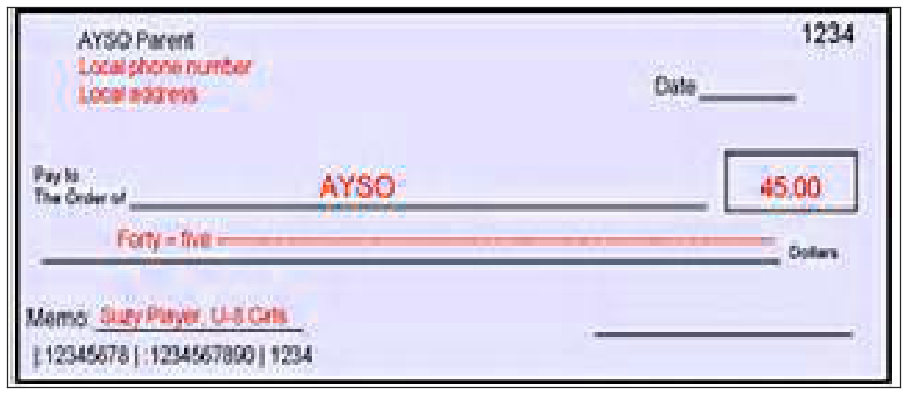

In [30]:
display_image(data[5])

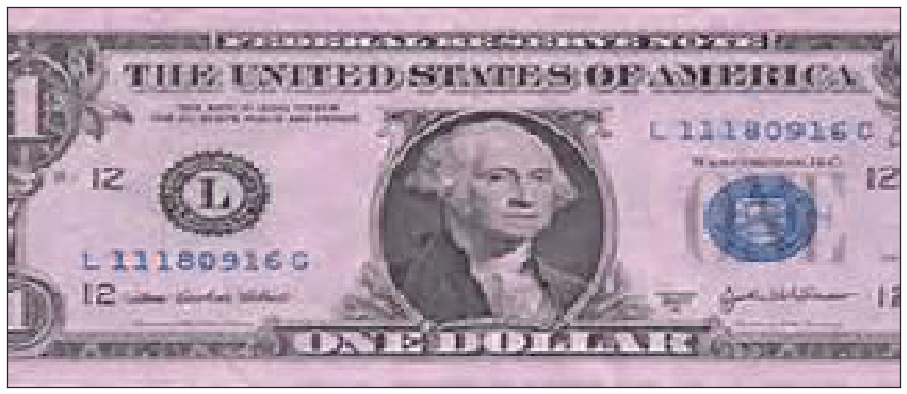

In [31]:
display_image(data[86])

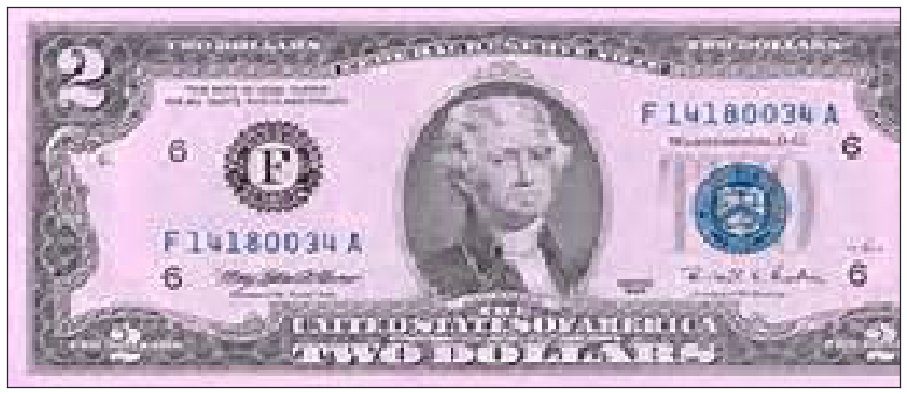

In [32]:
display_image(data[40])

In [33]:
pca = PCA(n_components=60)
X = pca.fit_transform(data)
print('for example, first 60 principal component explains', pca.explained_variance_ratio_.sum(), 'of variation')

for example, first 60 principal component explains 0.942527187933 of variation


In [34]:
df = pd.DataFrame({"y":y, "label":np.where(y==1, "check", "dollar")})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] = X[:,i]
df.head()

,label,y,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,...,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
0,check,1,-22536.362571,-2428.344273,-2133.776611,-328.316599,-1065.238744,79.784285,-425.042048,622.549762,...,-534.703353,157.311215,302.760426,-202.821138,-165.146240,-516.202406,-109.258244,-8.285951,-126.766120,378.196595
1,check,1,-22226.658684,-709.256162,-288.827200,-1300.637049,-792.086599,217.479010,1076.676485,-2114.947432,...,-360.203523,-34.534107,182.783318,309.873052,462.475395,-468.596615,-37.286626,208.334004,-56.715989,32.187515
2,check,1,-17364.260784,-4252.026933,793.802328,-1362.074385,-374.239760,3142.081021,2514.244391,1443.897968,...,-2750.958095,-1512.264150,997.188585,-2102.125268,-1014.503269,-1741.263179,-1761.733633,-217.994068,-1618.877128,842.084604
3,check,1,-22847.256199,-900.592772,577.205997,-180.308820,-733.123671,-107.923719,1442.004284,-1070.142335,...,6.649874,-61.980121,-99.340585,-301.790924,423.769575,294.836695,726.827135,-814.404342,315.146017,129.629685
4,check,1,-15868.672595,3259.492074,506.796753,-919.633250,2166.560928,-981.607642,-1669.817193,-391.266052,...,-816.052782,-2562.696107,59.482384,-86.581025,3174.701051,2429.254650,58.175919,-1475.245857,-2107.104221,-1971.125872


In fact, even the first PC is quite enough to help identify the feature.

In [35]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=322*137*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

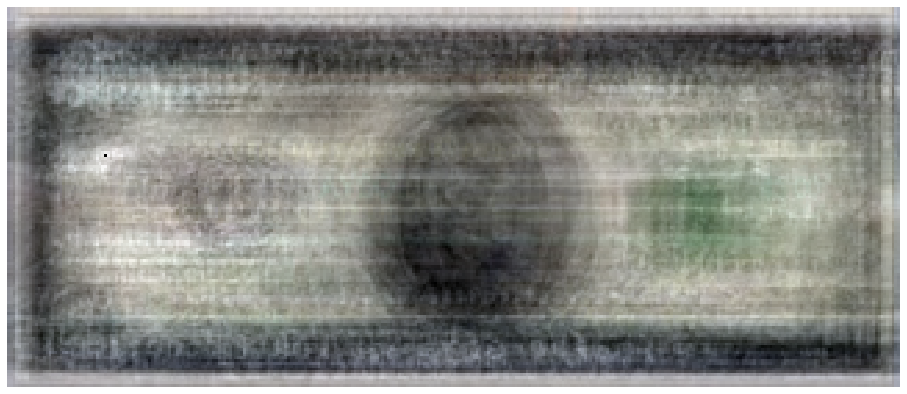

In [36]:
display_component(pca,0)

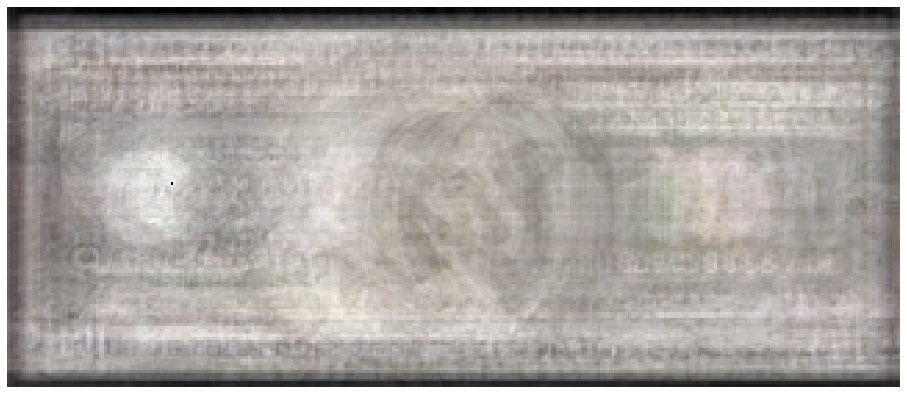

In [37]:
display_component(pca,1)

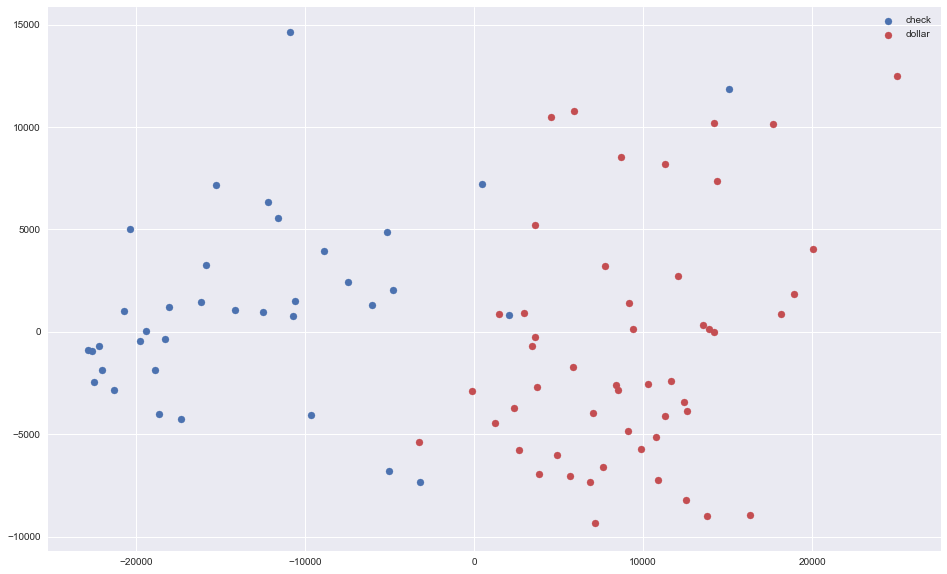

In [38]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]
colors = [c0, c2]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()

Eigenvalues and eigenvectors

Mathmatically, Eigenvalue $\lambda$ and eigenvector $v$ of a square $n\times n$ matrix $A$ is such that
$$ Av=\lambda v $$



Variance Decomposition

A variance covariance matrix $A$ can be decomposed as $$ A=Q\Lambda Q^{-1} $$ where $Q$ is a $n\times n$ matrix with eigenvector $v_{k}$ of $A$ in kth column, and $\Lambda$ is a diagonal matrix with corresponding eigenvalues at diagonal, $\Lambda_{kk}=\lambda_{k}$. 

$\lambda_{k}$ measures how much variation is explained by the kth eigenvector (factor).

### Return decomposition

In [39]:
returns =msf2[['PERMNO', 'RET']].reset_index().set_index(['PERMNO', 'date']).unstack('PERMNO')
returns.columns = returns.columns.droplevel()
returns.head()

PERMNO,10107,12490,14593,26403,57665
date,,,,,
1994-01-31,0.055814,0.000000,0.119658,0.109971,0.081081
1994-02-28,-0.030837,-0.059735,0.118168,0.015873,0.035000
1994-03-31,0.027273,0.033097,-0.089041,-0.125000,0.028019
1994-04-30,0.091445,0.052632,-0.097744,0.013690,0.011792
1994-05-31,0.162162,0.100000,-0.021000,0.020588,0.100233


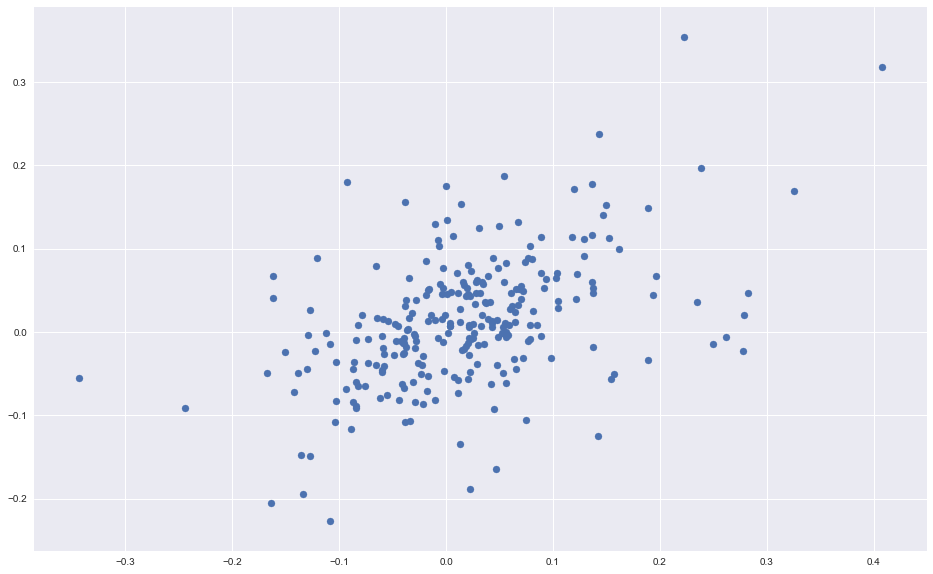

In [40]:
plt.scatter(returns[10107], returns[12490])

In [41]:
# standardize, aka demean
X = returns.values
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [42]:
# eigen decomposition
cov_mat = np.cov(X_std.T)
# same as decomposing the correlation matrix
# cor_mat = np.corrcoef(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.50428203 -0.18008441  0.55822127 -0.61222236  0.1638354 ]
 [-0.53158012 -0.18488726 -0.74848433 -0.254737   -0.24107995]
 [-0.41847218 -0.45508316  0.04572407  0.6412558   0.45219538]
 [-0.45244932  0.34051482  0.31697754  0.38609461 -0.65558788]
 [-0.28860502  0.78123958 -0.15998365  0.00384575  0.52987008]]

Eigenvalues 
[ 2.15971442  1.01318529  0.49210684  0.66689774  0.68725279]


In [43]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
    print('Everything ok!')

Everything ok!
Everything ok!
Everything ok!
Everything ok!
Everything ok!


In [44]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.15971442464
1.01318529441
0.68725278625
0.666897740726
0.492106842097


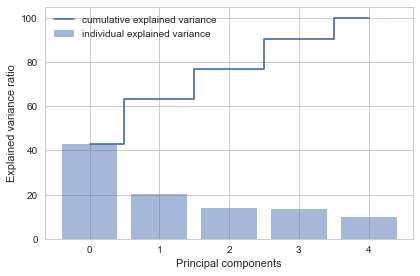

In [45]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(5), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(5), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [46]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(5,1),
                      eig_pairs[1][1].reshape(5,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.50428203 -0.18008441]
 [-0.53158012 -0.18488726]
 [-0.41847218 -0.45508316]
 [-0.45244932  0.34051482]
 [-0.28860502  0.78123958]]
